# Notebook 3: Preprocessing, Modeling and Evaluation

Welcome to Notebook 3! In this notebook we develop three models with both CountVectorization and Tfidf Vectorization (six total models) in order to predict whether combined title + selftext posts come from OCD or Anxiety subreddits. Throughout the model pipelines we offer the gridsearch the opportunity to select words from our own stop words list that was developed in the previous notebook. 

After model development we take the best model (the logistic regression with tfidf vectorization) and look at posts that we misclassified. We create a separate stopwords classification with all of these words and feed them back into the parameters. When given the choice the model does not select from this stopword list. When not given the choice (between none, english and my_stopwords3) and only my_stopwords3 the accuracty decreases. Next, we pickle the log reg tfidf pipeline and pass it onto Notebook 4 to create a streamlit app.

We evaluate the performance of the models in each step and end with our conclusions.

### Making Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Reading in CSV 

In [2]:
df = pd.read_csv('./data/after_eda.csv')

### Mapping 0's and 1

In [3]:
df['subreddit'] = df['subreddit'].map({'OCD':1, 'Anxiety':0})

### Train/test and stopwords

In [4]:
X = df['combined']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [5]:
my_stopwords2 = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['just', 
            'like', 've', 'don','really', 'things', 'deleted', 'feel', 'want', 'years', 
            'help', 'going', 'make', 'day', 'having', 'bad', 'got', 'way', "I'm", "I've", "I'll", 
            'n', 't', 's', 'm', 'g', 'll', "'ll", "'m", "'ve", 'ha', 'le', 'thing', 'u', 'wa', 'year']

# 1. Preprocessing: Vectorizing

## Vectorizing with Countvectorizer

In [6]:
# cvec = CountVectorizer(stop_words = my_stopwords2)

# cvec.fit(X_train)
# X_train_cv = cvec.transform(X_train)
# X_test_cv = cvec.transform(X_test)
# X_train_cv_df = pd.DataFrame(X_train_cv.todense(), columns = cvec.get_feature_names())
# X_test_cv_df = pd.DataFrame(X_test_cv.todense(), columns = cvec.get_feature_names())

In [7]:
# X_train_cv_df.head()

,00,000,000000000001,00am,00pm,01,03,039,05,053,...,zaps,zero,ziploc,zipped,zofran,zoloft,zombie,zone,zoned,zyprexa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vectorizing with Tfidf

This will be useful for use in the random forest. 

In [10]:
# tvec = TfidfVectorizer(stop_words = my_stopwords2)

# tvec.fit(X_train)
# X_train_tf = tvec.transform(X_train)
# X_test_tf = tvec.transform(X_test)
# X_train_tf_df = pd.DataFrame(X_train_tf.todense(), columns = tvec.get_feature_names())
# X_test_tf_df = pd.DataFrame(X_test_tf.todense(), columns = tvec.get_feature_names())

# X_train_tf_df

# 2. Modeling

# Baseline Model

Given that we have pulled the same number of observations from each dataset and removed no observations in the cleaning process a .5 baseline is what we should expect.

In [11]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

# Model 1: Logistic Regression

Below we have two Logistic Regression models, both in pipelines with gridsearch. The first uses CountVector vectorized data and the other uses Tfidf vectorized data. Both performed extremely well in comparison to baseline and far exceeded expectations given the potential for misdiagnosis of these two disorders.

Both models were overfit but the log reg with tfidf was less so with a train test score of .956 and .908 respectively. The cvec performed slightly better on test .913, but was more significantly overfit with .996. These accuracy scores were the highest of all the models and given that the log reg with tfidf was slightly less overfit, even though it was .005 less accurate, it was chosen as the production model. 

## M1.1 LogReg with cvec

In [12]:
## Code from 5.04 modified to fit needs
pipe_lr_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('log_reg', LogisticRegression(solver='liblinear'))
])

pipe_lr_cv_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__stop_words': [None, 'english', my_stopwords2],
    'cvec__ngram_range': [(1,1), (1,2)]
}
pipe_lr_cv.fit(X_train, y_train)
gs_lr_cv = GridSearchCV(pipe_lr_cv, 
                        param_grid = pipe_lr_cv_params, 
                        cv=5)

gs_lr_cv.fit(X_train, y_train);

In [13]:
print(gs_lr_cv.best_score_)
gs_lr_cv.best_params_

0.861111111111111


{'cvec__max_features': 5000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [14]:
print(f'gs_lr_cv train score: {gs_lr_cv.score(X_train, y_train)}')
print(f'gs_lr_cv test score: {gs_lr_cv.score(X_test, y_test)}')

gs_lr_cv train score: 0.9961111111111111
gs_lr_cv test score: 0.9133333333333333


### Visualizing the Most Important Words

In [15]:
##Base code for this vis from https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214?gi=1195fc896ccd

feat_lr_cv = pipe_lr_cv.named_steps['cvec'].get_feature_names()

coefs_lr_cv = pipe_lr_cv.named_steps['log_reg'].coef_.flatten()

zip_lr_cv = zip(feat_lr_cv, coefs_lr_cv)
df_lr_cv = pd.DataFrame(zip_lr_cv, columns=["feature", "coef"])

df_lr_cv["abs_value"] = df_lr_cv["coef"].apply(lambda x: abs(x))
df_lr_cv["colors"] = df_lr_cv["coef"].apply(lambda x: "blue" if x > 0 else "red")
df_lr_cv = df_lr_cv.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

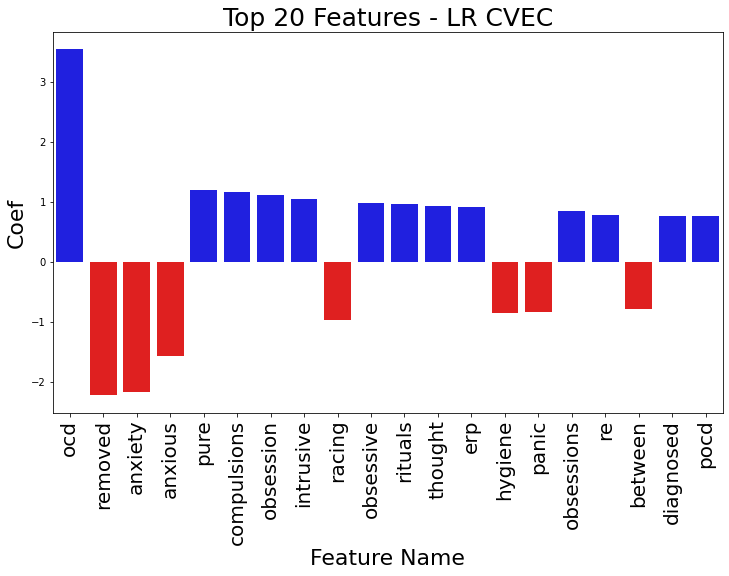

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=df_lr_cv.head(20),
           palette=df_lr_cv.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features - LR CVEC", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

### Getting Predictions and Confusion Matrix (lr_cv)

In [17]:
#Code from lesson 5.04 modified to fit my needs

preds_gs_lr_cv = gs_lr_cv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_lr_cv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

Specificity: 0.9191919191919192
Sensitivity: 0.9075907590759076


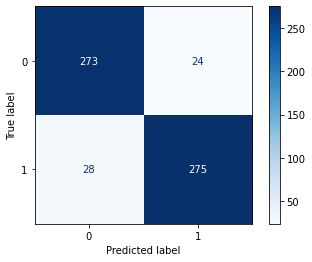

In [18]:
plot_confusion_matrix(gs_lr_cv, X_test, y_test, cmap='Blues', values_format='d');

## M1.2 LogReg with tvec

In [19]:
## Code from 5.04 modified to fit needs
pipe_lr_tv = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log_reg', LogisticRegression(solver='liblinear'))
])

pipe_lr_tv_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english', my_stopwords2],
    'tvec__ngram_range': [(1,1), (1,2)]
}
pipe_lr_tv.fit(X_train, y_train)
gs_lr_tv = GridSearchCV(pipe_lr_tv, 
                        param_grid = pipe_lr_tv_params, 
                        cv=5)

gs_lr_tv.fit(X_train, y_train);

In [20]:
print(gs_lr_tv.best_score_)
gs_lr_tv.best_params_

0.8822222222222222


{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [21]:
print(f'gs_lr_tv train score: {gs_lr_tv.score(X_train, y_train)}')
print(f'gs_lr_tv test score: {gs_lr_tv.score(X_test, y_test)}')

gs_lr_tv train score: 0.9561111111111111
gs_lr_tv test score: 0.9083333333333333


### Visualizing the Most Important Words

In [22]:
feat_lr_tv = pipe_lr_tv.named_steps['tvec'].get_feature_names()

coefs_lr_tv = pipe_lr_tv.named_steps['log_reg'].coef_.flatten()

zip_lr_tv = zip(feat_lr_tv, coefs_lr_tv)
df_lr_tv = pd.DataFrame(zip_lr_tv, columns=["feature", "coef"])

df_lr_tv["abs_value"] = df_lr_tv["coef"].apply(lambda x: abs(x))
df_lr_tv["colors"] = df_lr_tv["coef"].apply(lambda x: "blue" if x > 0 else "red")
df_lr_tv = df_lr_tv.sort_values("abs_value", ascending=False)

In [23]:
df_lr_tv.to_csv('./data/df_lr_tvd.csv', index = False)

Text(0.5, 0, 'Feature Name')

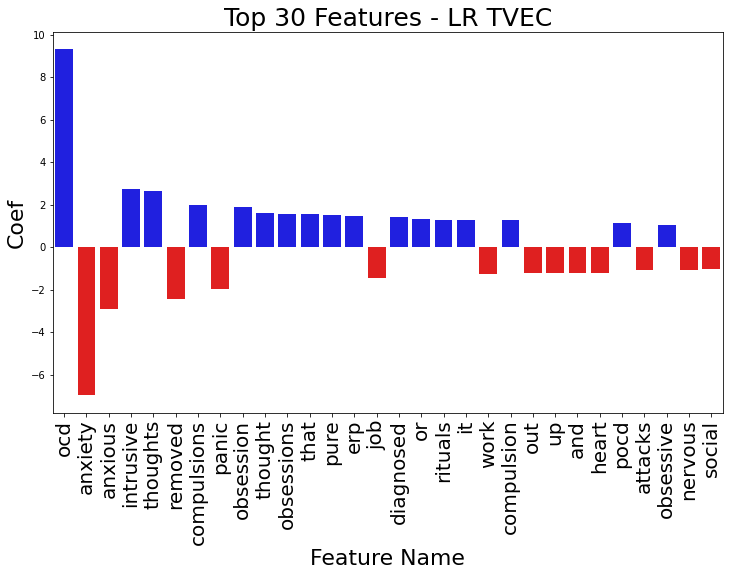

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=df_lr_tv.head(30),
           palette=df_lr_tv.head(30)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 30 Features - LR TVEC", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

### Getting predictions and Confusion Matrix (lr_tv)

In [26]:
#Code from lesson 5.04 modified to fit my needs

preds_gs_lr_tv = gs_lr_tv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_lr_tv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

plot_confusion_matrix(gs_lr_tv, X_test, y_test, cmap='Greens', values_format='d');

# Model 2: Multinomial Bayes pipeline with Grid Search

Below we have two Multinomial Bayes models, both in pipelines with gridsearch. The first uses CountVector vectorized data and the other uses Tfidf vectorized data. Both performed extremely well in comparison to baseline and far exceeded expectations given the potential for misdiagnosis of these two disorders.

Both models were overfit, although not substantially so and in fact, these two models exhibited the least overfitting of any of the models. However there was a slight downtick in accuracy and therefore neither one was chosen as the production model.

## M2.1 Multinomial Bayes with cvec and Grid Search

In [27]:
## Code from 5.04 modified to fit needs
pipe_nb_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_cv_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__stop_words': [None, 'english', my_stopwords2],
    'cvec__ngram_range': [(1,1), (1,2)]
}

pipe_nb_cv.fit(X_train, y_train)

gs_nb_cv = GridSearchCV(pipe_nb_cv, 
                        param_grid = pipe_nb_cv_params, 
                        cv=5)

gs_nb_cv.fit(X_train, y_train);

In [28]:
print(gs_nb_cv.best_score_)
gs_nb_cv.best_params_

0.8744444444444444


{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['few',
  'throughout',
  'nine',
  'thin',
  'this',
  'hers',
  'either',
  'once',
  'beforehand',
  'interest',
  'again',
  'fire',
  'she',
  'up',
  'towards',
  'sincere',
  'all',
  'third',
  'along',
  'mostly',
  'still',
  'namely',
  'a',
  'are',
  'in',
  'de',
  'cry',
  'not',
  'no',
  'thus',
  'one',
  'from',
  'been',
  'that',
  'next',
  'which',
  'enough',
  'couldnt',
  'whom',
  'describe',
  're',
  'ever',
  'beyond',
  'almost',
  'such',
  'seemed',
  'get',
  'via',
  'always',
  'also',
  'bill',
  'at',
  'noone',
  'whereafter',
  'same',
  'back',
  'top',
  'onto',
  'how',
  'ten',
  'keep',
  'seem',
  'whoever',
  'about',
  'sometimes',
  'be',
  'has',
  'might',
  'ours',
  'anything',
  'against',
  'me',
  'never',
  'become',
  'herein',
  'after',
  'nowhere',
  'through',
  'these',
  'whereby',
  'now',
  'amoungst',
  'whether',
  'moreover',
  'nothing',


In [29]:
print(f'gs_nb_cv train score: {gs_nb_cv.score(X_train, y_train)}')
print(f'gs_nb_cv test score: {gs_nb_cv.score(X_test, y_test)}')

gs_nb_cv train score: 0.9122222222222223
gs_nb_cv test score: 0.88


### Getting predictions and Confusion Matrix (nb_cv)

In [30]:
#Code from lesson 5.04 modified to fit my needs
preds_gs_nb_cv = gs_nb_cv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_nb_cv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

Specificity: 0.9191919191919192
Sensitivity: 0.8415841584158416


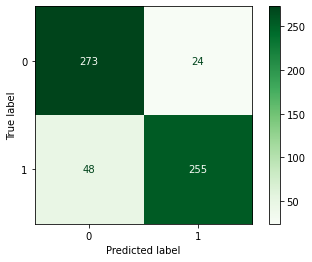

In [31]:
plot_confusion_matrix(gs_nb_cv, X_test, y_test, cmap='Greens', values_format='d');

## M2.2 Multinomial Bayes with GS and Tvec Pipeline

In [32]:
## Code from 5.04 modified to fit needs
pipe_nb_tv = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_tv_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english', my_stopwords2],
    'tvec__ngram_range': [(1,1), (1,2)]
}

pipe_nb_tv.fit(X_train, y_train)

gs_nb_tv = GridSearchCV(pipe_nb_tv, 
                        param_grid = pipe_nb_tv_params, 
                        cv=5)

gs_nb_tv.fit(X_train, y_train);

In [33]:
print(gs_nb_tv.best_score_)
gs_nb_tv.best_params_

0.86


{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['few',
  'throughout',
  'nine',
  'thin',
  'this',
  'hers',
  'either',
  'once',
  'beforehand',
  'interest',
  'again',
  'fire',
  'she',
  'up',
  'towards',
  'sincere',
  'all',
  'third',
  'along',
  'mostly',
  'still',
  'namely',
  'a',
  'are',
  'in',
  'de',
  'cry',
  'not',
  'no',
  'thus',
  'one',
  'from',
  'been',
  'that',
  'next',
  'which',
  'enough',
  'couldnt',
  'whom',
  'describe',
  're',
  'ever',
  'beyond',
  'almost',
  'such',
  'seemed',
  'get',
  'via',
  'always',
  'also',
  'bill',
  'at',
  'noone',
  'whereafter',
  'same',
  'back',
  'top',
  'onto',
  'how',
  'ten',
  'keep',
  'seem',
  'whoever',
  'about',
  'sometimes',
  'be',
  'has',
  'might',
  'ours',
  'anything',
  'against',
  'me',
  'never',
  'become',
  'herein',
  'after',
  'nowhere',
  'through',
  'these',
  'whereby',
  'now',
  'amoungst',
  'whether',
  'moreover',
  'nothing',


In [34]:
print(f'gs_nb_tv train score: {gs_nb_tv.score(X_train, y_train)}')
print(f'gs_nb_tv test score: {gs_nb_tv.score(X_test, y_test)}')

gs_nb_tv train score: 0.9261111111111111
gs_nb_tv test score: 0.87


### Confusion Matrix (nb_tv)

In [35]:
#Code from lesson 5.04 modified to fit my needs
preds_gs_nb_tv = gs_nb_tv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_nb_tv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

Specificity: 0.9259259259259259
Sensitivity: 0.8151815181518152


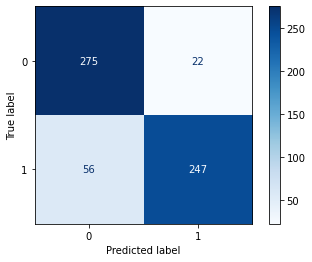

In [36]:
plot_confusion_matrix(gs_nb_tv, X_test, y_test, cmap='Blues', values_format='d');

# Model 3: Random Forest with Gridsearch

Below we have two Random Forest models, both in pipelines with gridsearch. The first uses CountVector vectorized data and the other uses Tfidf vectorized data. Both performed extremely well in comparison to baseline and far exceeded expectations given the potential for misdiagnosis of these two disorders.

Both models were significantly overfit, the most of any model in the project, however they did have test accuracy roughly comparable to the logreg models. They were not chosen as production model because of the overfitting problem.

## 3.1 Random Forest with cvec and Gridsearch

In [37]:
## Code from 5.04 modified to fit needs
pipe_rf_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_rf_cv_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__stop_words': [None, 'english', my_stopwords2],
    'cvec__ngram_range': [(1,1), (1,2)]
}

pipe_rf_cv.fit(X_train, y_train)

gs_rf_cv = GridSearchCV(pipe_rf_cv, 
                        param_grid = pipe_rf_cv_params, 
                        cv=5)

gs_rf_cv.fit(X_train, y_train);

In [38]:
print(gs_rf_cv.best_score_)
gs_rf_cv.best_params_

0.8961111111111111


{'cvec__max_features': 4000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [39]:
print(f'gs_rf_cv train score: {gs_rf_cv.score(X_train, y_train)}')
print(f'gs_rf_cv test score: {gs_rf_cv.score(X_test, y_test)}')

gs_rf_cv train score: 1.0
gs_rf_cv test score: 0.8916666666666667


### Getting Predictions and Confusion Matrix (rf_cv)

In [40]:
#Code from lesson 5.04 modified to fit my needs
preds_gs_rf_cv = gs_rf_cv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_rf_cv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

Specificity: 0.9225589225589226
Sensitivity: 0.8613861386138614


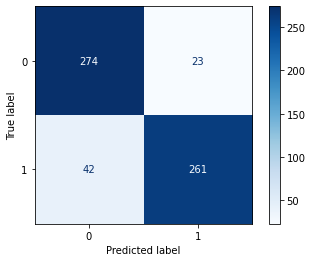

In [41]:
plot_confusion_matrix(gs_rf_cv, X_test, y_test, cmap='Blues', values_format='d');

## 3.2 Random Forest with tvec and Gridsearch

In [42]:
## Code from 5.04 modified to fit needs
pipe_rf_tv = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_rf_tv_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english', my_stopwords2],
    'tvec__ngram_range': [(1,1), (1,2)]
}

pipe_rf_tv.fit(X_train, y_train)

gs_rf_tv = GridSearchCV(pipe_rf_tv, 
                        param_grid = pipe_rf_tv_params, 
                        cv=5)

gs_rf_tv.fit(X_train, y_train);

In [43]:
print(gs_rf_tv.best_score_)
gs_rf_tv.best_params_

0.8911111111111112


{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [44]:
print(f'gs_rf_tv train score: {gs_rf_tv.score(X_train, y_train)}')
print(f'gs_rf_tv test score: {gs_rf_tv.score(X_test, y_test)}')

gs_rf_tv train score: 0.9972222222222222
gs_rf_tv test score: 0.8916666666666667


### Getting Predictions and Confusion Matrix (rf_tv)

In [45]:
#Code from lesson 5.04 modified to fit my needs
preds_gs_rf_tv = gs_rf_tv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_gs_rf_tv).ravel()

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print('Specificity:', spec)
print('Sensitivity:', sens)

Specificity: 0.9393939393939394
Sensitivity: 0.8448844884488449


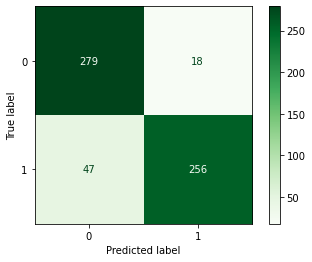

In [46]:
plot_confusion_matrix(gs_rf_tv, X_test, y_test, cmap='Greens', values_format='d');

# 4. Misclassified posts

Here we identify misclassified posts and then take the text from these misclassified posts and pass it as optional stopword parameters in the log reg tfidf gridsearch to see if it improves accuracy. (Spoiler alert... it doesn't). 

Furthermore we do sentiment analsysis on the posts to see if there is a difference between sentiment in these posts and the full dataframe. It doesn't seem like there is. 

In [67]:
## Worked with Andy to develop this misclassification rubric

y_test_df = pd.DataFrame(y_test).copy()

X_test_df = pd.DataFrame(X_test).copy()

In [67]:
y_test_df['preds'] = preds_gs_lr_tv

y_test_df.head()

In [67]:
X_test.head()

In [67]:
new_df = pd.concat([X_test_df, y_test_df], axis = 1)

type(new_df)

In [67]:
new_df.head()

In [67]:
only_mis = new_df.loc[new_df['preds'] - new_df['subreddit'] != 0]

only_mis.head()

In [69]:
only_mis_i = only_mis.reset_index()

## 4.1 Sentiment Analysis on Misclassified Posts

In [72]:
sia = SentimentIntensityAnalyzer()

In [73]:
## Code from 5.03 modified to fit my needs
scores = []

for each in only_mis['combined']:
    current_scores = sia.polarity_scores(each)
    scores.append(current_scores)

In [74]:
scores_df = pd.DataFrame(scores)

In [75]:
scores_df['compound'].mean()

-0.2491690909090909

In [76]:
scores_df.head()

,neg,neu,pos,compound
0,0.038,0.883,0.079,0.5216
1,0.346,0.572,0.081,-0.9976
2,0.218,0.683,0.099,-0.9952
3,0.064,0.800,0.136,0.8126
4,0.113,0.823,0.064,-0.5921


In [77]:
mis_df = only_mis_i.merge(scores_df, left_index =True, right_index=True)

In [78]:
mis_df.shape

(55, 8)

In [79]:
mis_df.head()

,index,combined,subreddit,preds,neg,neu,pos,compound
0,855,i went to a barbecue today and the ribs were s...,1,0,0.038,0.883,0.079,0.5216
1,1719,"I believe that everyone fears something, wheth...",0,1,0.346,0.572,0.081,-0.9976
2,111,Hello!\n\nToday my SO and I are going to see t...,1,0,0.218,0.683,0.099,-0.9952
3,1739,I've been on Prozac for about 6-7 months now a...,0,1,0.064,0.800,0.136,0.8126
4,1196,We have a day long meeting in my team so we we...,1,0,0.113,0.823,0.064,-0.5921


In [80]:
mis_df.sort_values(by='compound', ascending=False).head(15)

,index,combined,subreddit,preds,neg,neu,pos,compound
31,926,\nHi all! My doctor has increased my sertralin...,1,0,0.000,0.648,0.352,0.9215
53,1043,Hi! Last week I had my first (I think) of what...,1,0,0.056,0.843,0.101,0.8365
3,1739,I've been on Prozac for about 6-7 months now a...,0,1,0.064,0.800,0.136,0.8126
13,1310,Saw this today on the freeway and chuckled xD,0,1,0.000,0.455,0.545,0.7351
5,218,"Yes, it’s a dead meme format. No, I don’t giv...",1,0,0.161,0.521,0.318,0.6486
49,423,It bothers me every time I drive over it; I fe...,1,0,0.069,0.786,0.145,0.6352
39,889,Hi! Im here to let you know that the Spotify ...,1,0,0.000,0.845,0.155,0.5399
19,279,Hey guys! I was just wondering if anyone else ...,1,0,0.025,0.929,0.046,0.5255
0,855,i went to a barbecue today and the ribs were s...,1,0,0.038,0.883,0.079,0.5216
32,1864,Does anyone take benzos? If so how does it help?,0,1,0.000,0.746,0.254,0.4696


In [81]:
mis_df['index'] = mis_df['index'].astype('str')

#### Plotting misclassified 'compound' sentiment analysis

<BarContainer object of 55 artists>

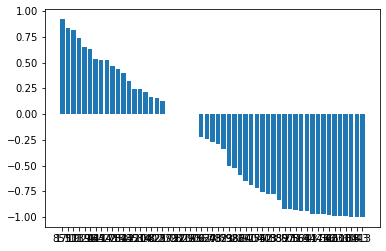

In [82]:
plt.bar(mis_df['index'], mis_df['compound'].sort_values(ascending=False))

## 4.2 Most Common Misclassified Words

In [83]:
#Code from lesson 5.04 modified to fit my needs
my_stopwords2 = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['just', 'like', 've', 'don','really', 'things', 'deleted', 'feel', 'want', 'years', 'help', 'going', 'make', 'day', 'having', 'bad', 'got', 'way', "I'm", "I've", "I'll", 'n', 't', 's', 'm', 'g', 'll']

In [84]:
cvec = CountVectorizer(stop_words = my_stopwords2)

x = mis_df['combined']

cvec.fit(x)
z = cvec.transform(x)
z_df = pd.DataFrame(z.todense(), columns = cvec.get_feature_names())

In [85]:
pd.DataFrame(z_df.sum().sort_values(ascending = False).head(20))

,0
know,29
anxiety,27
fear,20
work,15
time,13
started,12
thought,11
think,11
right,11
people,11


#### Plotting most common misclassified words

<AxesSubplot:>

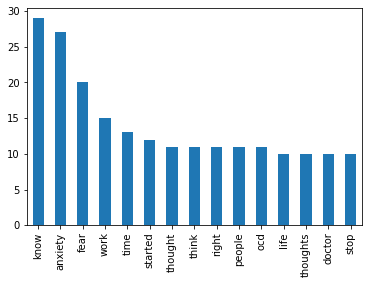

In [86]:
z_df.sum().sort_values(ascending = False).head(15).plot(kind='bar')

### Making a list of stopwords from misclassified posts

In [ ]:
z_mis = z_df.sum().sort_values(ascending = False)

In [ ]:
z_mis_df = pd.DataFrame(z_mis)

In [ ]:
z_mis_df.reset_index()

In [ ]:
z_l = []
for i in z_mis_df.index:
    z_l.append(i)

In [ ]:
z_l;

In [ ]:
my_stopwords3 = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['just', 
            'like', 've', 'don','really', 'things', 'deleted', 'feel', 'want', 'years', 
            'help', 'going', 'make', 'day', 'having', 'bad', 'got', 'way', "I'm", "I've", "I'll", 
            'n', 't', 's', 'm', 'g', 'll', "'ll", "'m", "'ve", 'ha', 'le', 'thing', 'u', 'wa', 'year'] + z_l

# Model 4: Logreg tvec with new stopwords as optional params

The model fails to beat the accuracy of the original log reg tfidf model and has roughly the same amount of overfitting.

In [ ]:
## Code from 5.04 modified to fit needs
pipe_lr_tv2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log_reg', LogisticRegression(solver='liblinear'))
])

pipe_lr_tv2_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english', my_stopwords3],
    'tvec__ngram_range': [(1,1), (1,2)]
}
pipe_lr_tv2.fit(X_train, y_train)
gs_lr_tv2 = GridSearchCV(pipe_lr_tv2, 
                        param_grid = pipe_lr_tv2_params, 
                        cv=5)

gs_lr_tv2.fit(X_train, y_train);

In [ ]:
print(gs_lr_tv2.best_score_)
gs_lr_tv2.best_params_

In [ ]:
print(f'gs_lr_tv train score: {gs_lr_tv2.score(X_train, y_train)}')
print(f'gs_lr_tv test score: {gs_lr_tv2.score(X_test, y_test)}')

# 5. Export best model as a pickle

Here we export the best model (log reg tfidf) to a pickle to use in Notebook 4 where we develop the Streamlit app. 

In [ ]:
import pickle

In [ ]:
with open('./models/ocd_pipe.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pipe_lr_tv, pickle_out)

with open('./models/ocd_pipe.pkl', 'rb') as pickle_in:
    pipe = pickle.load(pickle_in)

In [ ]:
pipe.classes_

In [ ]:
pipe.predict(['I am extremely overwhelmed with intrusive ocd thoughts'])

In [ ]:
## Interactive Streamlit

In [ ]:
user_input = input('Enter some text:')
prediction = pipe.predict([user_input])[0] 

print(f'Based on your input it is more likely you have: {prediction}')

# 6. Conclusions and further steps

Overall, the model selected for production was the log reg with tfidf which had a training score of .956 and testing score of .908. After extensive EDA in Notebook 2 we can make several interesting observations about the data, perhaps most important to the project statement: that the sentiment of each subreddit and the dataframe as a whole was negative. 

This sets the scene for the Streamlit app based off a pickle from our production model that poses the following question to the user: **'Tell us about your internal mental environment on days/at times when you feel off balance.'** In the Streamlit app we also included a sentiment analysis given that, if this were to be used as pre-assessment in a clinical environment, it may be useful to the caregiver to have information about the overall sentiment of the user's response to the question that led to the non-medical, first-stage diagnosis.

In response to the initial problem statement of whether or not we can develop a non-medical, first-step diagnostic tool, the answer is **yes** and we have reasonable grounds to believe it may be fairly accurate for some users. Again, this is non-medical and should not replace guidance from a trained medical professional but it is, perhaps, a benefit to those suffering from what might turn out to be OCD or an Anxiety disorder.

## Further Steps:

There are three steps that stand out as highest priority:

    1. Increasing accuracy of the model by training the model on more data, analyzing misclassifications more carefully and implementing more preprocessing tools like lemmatization.
   
    2. Getting input from users and professionals. it's hard to think of any useful tool or service that should be developed by a single datascientist. Instead, tools hsould be developed with input from the actual users as well as experts in the field. 
    
    3. Further applications: Ideally this is just a start and future tools could analyze free text comments from users in subreddits dedicated to other mental health disorders.